In [1]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os
#data_file_path = os.path.join(os.path.dirname(__file__), "YX.csv")
data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")
#data_file_path = os.path.join(os.getcwd(), "Compustat.csv")

In [3]:
import pandas as pd
#finalData = pd.read_csv(data_file_path, nrows=10_000)
finalData = pd.read_csv(data_file_path)
finalData


# finalData = dataset.map(..., num_parallel_calls=10)
# finalData = dataset.prefetch(buffer_size)

,returns,gvkey,fdateq,datacqtr,curcdq,accdq,acoq,acoxq,actq,ancq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
0,4.971591,1166,20100907,2010Q2,EUR,113.1330,55.8040,55.8040,817.555,274.2700,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
1,10.121786,1166,20101105,2010Q3,EUR,87.2820,70.5220,70.5220,839.315,253.3070,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
2,44.138609,1166,20110330,2010Q4,EUR,63.8670,67.9700,67.9700,934.149,279.9680,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
3,-37.643181,1166,20110811,2011Q2,EUR,284.1220,82.1470,82.1470,1216.409,345.5600,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
4,48.155340,1166,20120331,2011Q4,EUR,110.9440,97.0650,97.0650,1195.780,386.4410,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59596,-7.707181,352723,20220903,2022Q2,CNY,174.2099,61.5137,61.4806,2523.141,203.3685,...,Shanghai,12,2010,201060,20,20106020,I,CHN,332912,3490
59597,8.107603,352948,20220821,2022Q1,INR,29.2730,71.4670,69.3530,1512.461,646.6230,...,Hyderabad,3,1510,151040,15,15104050,I,IND,331110,3312
59598,84.512350,353064,20220908,2022Q2,CNY,1354.9970,63.4908,50.9666,6807.913,1457.3440,...,Beijing,12,2510,251010,25,25101010,I,CHN,336320,3714
59599,-10.037170,353097,20220824,2022Q2,CNY,110.1364,13.1831,10.7148,1562.486,613.5332,...,Nanjing,12,3520,352030,35,35203010,I,CHN,325414,2836


In [ ]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
finalData.dtypes


testDF = pd.Dataframe({
    "A": [1, 2],
    "B": [6, 7]
}
)


In [21]:
# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX

import numpy as np

finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
#finalData["fdateq"] = pd.to_datetime(finalData["datacqtr"], format = "%Y%q") #check quarter format


#Currently not grouped by quarter
finalData = finalData.sort_values(by=['datacqtr', "fdateq"])

trainSize = round(len(finalData.index)*0.4)
validationSize = round(len(finalData.index)*0.7)

Y = finalData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]

X = finalData.loc[:, finalData.columns != "returns"]


factorCols = ["gvkey",  "sic", "naics", "loc", "idbflag",
              "gsubind", "ggroup", "gind", "gsector",
              "fic", "city", "fyrc",
              "curcdq", "exchg"]

X[factorCols] = X[factorCols].astype("str")



X = X.select_dtypes(include=[np.number])
#X = X.dropna()





In [88]:
X.dtypes

finalData


,returns,gvkey,fdateq,datacqtr,curcdq,accdq,acoq,acoxq,actq,ancq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
4029,-3.367876,200144,2010-02-18,2009Q4,ARS,134.5456,34.2808,13.2956,2228.9330,4987.7120,...,Buenos Aires,6,1510,151040,15,15104010,I,ARG,331313,3334
5176,-8.876812,201336,2010-02-22,2009Q4,ARS,342.5160,98.6690,63.8040,1151.5720,5216.6420,...,Buenos Aires,6,3020,302020,30,30202010,B,ARG,999977,9997
34651,0.628931,278800,2010-03-02,2009Q4,ARS,26.9737,6.7059,4.5902,440.8773,148.4538,...,Buenos Aires,12,3020,302020,30,30202030,I,ARG,3114,2030
9291,1.560847,206547,2011-02-12,2009Q4,HUF,586.0000,1234.0000,1234.0000,86717.0000,68975.0000,...,Budapest,9,3520,352020,35,35202010,I,HUN,325412,2834
38365,-33.637890,285237,2020-12-04,2009Q4,EUR,5.5242,0.6135,0.0573,21.1166,13.8050,...,Aigrefeuille-d'Aunis,8,2520,252020,25,25202010,I,FRA,336612,3730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58036,-12.051230,325357,2022-08-20,2022Q2,CNY,745.0450,58.2354,16.3817,10809.6900,2933.2940,...,Guangzhou,12,3510,351020,35,35102015,I,CHN,6215,8071
32981,3.551653,274159,2022-08-20,2022Q2,TWD,587.6160,48.5040,6.6760,5842.6520,2146.1050,...,Zhubei,12,4520,452020,45,45202030,I,TWN,334413,3674
20266,16.072100,246076,2022-08-20,2022Q2,TWD,45.3430,128.9580,0.6170,6104.5320,1049.9450,...,Taipei,12,2010,201070,20,20107010,I,TWN,325,2800
21405,67.173140,247969,2022-08-19,2022Q2,CNY,533.2028,233.9526,233.9526,3588.2920,1388.4280,...,Shanghai,12,4530,453010,45,45301020,I,HKG,334413,3674


In [24]:
#Ratio data
#xRatioData = finalData.apply(lambda x: x/finalData["revtq"])
xRatioData = X.div(finalData["revtq"].values, axis=0)
#xRatioData = xRatioData.dropna()



In [25]:
#Winsorised data
import scipy


XArray = np.asarray(xRatioData).astype('float32')
numberOfVariables = XArray.shape[1]

xWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.05, 0.95))
#yWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.05, 0.95))


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_X = scaler.fit_transform(XArray)
#scaled_X = np.apply_along_axis(func1d=scaler.fit_transform, axis=1, arr=X)


xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]



scaled_winX = scaler.fit_transform(xWinData)
xWinTrain, xWinVal, xWinTest = scaled_winX[:trainSize,:], scaled_winX[trainSize:validationSize,:], scaled_winX[validationSize:, :]



#scaled_X = scaled_X.apply(lambda x : x.reshape(-1, 1))
# droppedCols = ["ajexdi", "prccd", "trfd"]
# trainX.drop(droppedCols, axis=1, inplace=True)
# trainX['gvkey'] = trainX['gvkey'].astype(object)
# trainX['gvkey'] = trainX['gvkey'].astype(object)

#trainX.dtypes

In [216]:
#finalData.iloc[:trainSize,:] 
#finalData.iloc[trainSize:validationSize,:]
finalData.iloc[validationSize:, :]

,returns,gvkey,fdateq,datacqtr,curcdq,accdq,acoq,acoxq,actq,ancq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
31675,8.802817,272447,2020-09-04,2020Q2,CNY,709.8380,2099.3410,2099.3410,4620.2000,5865.1850,...,Shenyang,12,5020,502020,50,50202010,I,CHN,512,7812
12598,26.452340,212172,2020-09-04,2020Q2,TRY,9.7796,10.8574,2.1066,49.1481,107.8442,...,Bursa,12,2010,201060,20,20106020,I,TUR,333,3500
50086,154.356900,306392,2020-09-04,2020Q2,CNY,1739.0950,688.4356,685.2491,18791.5500,4819.3320,...,Hefei,12,2010,201040,20,20104010,I,CHN,335,3600
22185,3.770902,251298,2020-09-04,2020Q2,CNY,1945.2160,705.7704,705.7704,21143.1700,18348.9200,...,Anyang,12,1510,151040,15,15104050,I,CHN,331110,3312
25673,17.989420,259818,2020-09-04,2020Q2,CNY,443.8152,209.5154,204.1555,4655.3460,4696.5940,...,Beijing,12,1510,151040,15,15104020,I,CHN,327999,3290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59598,84.512350,353064,2022-09-08,2022Q2,CNY,1354.9970,63.4908,50.9666,6807.9130,1457.3440,...,Beijing,12,2510,251010,25,25101010,I,CHN,336320,3714
28056,0.645757,270423,2022-09-08,2022Q2,CNY,903.2434,150.6130,150.6130,6843.8260,9327.9770,...,Linhai,12,3520,352020,35,35202010,I,CHN,325411,2833
39257,-1.575758,286880,2022-09-08,2022Q2,KRW,6873.8880,11140.9000,4114.5270,244485.0000,394781.7000,...,Ulsan,12,2510,251010,25,25101010,I,KOR,3363,3714
12272,77.662340,211759,2022-09-08,2022Q2,CNY,550.7485,391.4168,391.4168,7632.0250,55421.1600,...,Shanghai,12,1010,101020,10,10102040,I,CHN,483111,4412


In [ ]:



groupedY = Y.groupby(["state", "gender"])["last_name"].count()
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]



groupedX = scaled_X.groupby(["state", "gender"])["last_name"].count()
xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]




In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [46]:
# model = Sequential([
#     Dense(units=16,  activation='relu'), #input_shape=(, 10, numberOfVariables),
#     Dense(units=32, activation='relu'),
#     Dense(units=1)
# ])


In [47]:
# model = tf.keras.Sequential()

# model.add(Dense(units=10,  activation='relu'))
# model.add(tf.keras.layers.Dropout(.5))
# model.add(Dense(units=10, activation='relu'))
# model.add(Dense(units=1))

In [48]:
# model.compile(optimizer="sgd",  # Adam(learning_rate=0.0001),
#               loss="MeanSquaredError", #'tf.keras.losses.MeanSquaredError()',
#               metrics=['accuracy'])

In [49]:
# model.fit(x=xTrain, y=yTrain,
#           batch_size=10, epochs=30, verbose=2)


In [50]:
# loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)

# model.predict(xVal, batch_size=128)

In [9]:
def NNfunction(modelType, layers, hidUnits, actvFunc, dropout, L1, L2, epo):
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=3, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    #callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")


    model = tf.keras.Sequential()

    if modelType == "LSTM":
        model.add(tf.keras.layers.LSTM(units=hidUnits, input_shape=(2,)))
    elif modelType == "GRU":
        model.add(tf.keras.layers.GRU(units=hidUnits))
    elif modelType == "SimpleRNN":
        # keras.layers.SimpleRNN(1, input_shape=[None, 1])
        model.add(tf.keras.layers.SimpleRNN(units=hidUnits))
    elif modelType == "Linear":
        model.add(Dense(units=1,
                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))   #insert lasso and ridge here
    else:
        model.add(Dense(units=hidUnits,
                        activation=actvFunc,
                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
        try: 
            for n in range(0, layers):
                model.add(Dense(units=hidUnits, activation=actvFunc))
                model.add(tf.keras.layers.Dropout(dropout))
                #scaler.fit_transform
                #tf.keras.layers.BatchNormalization(
        except:
            model.add(Dense(units=hidUnits, activation=actvFunc))
            model.add(tf.keras.layers.Dropout(dropout))

            
        model.add(Dense(units=1))



    model.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                  loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                  metrics=['accuracy'])




    # model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)
    


    model.fit(x=xWinTrain, y=yTrain,
              batch_size=32, epochs=epo,
              callbacks= [callback], verbose=2)

    loss_and_metrics = model.evaluate(xWinVal, yVal, batch_size=128)
    
    


    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    
    
    try:
        loss_and_metrics = [x for x in loss_and_metrics]
    except:     
        print(loss_and_metrics)

    return loss_and_metrics, model

    #model.predict(xVal, batch_size=128)

    





In [12]:
#Hyper-Parameters
modelType = ["Linear", "Forward", "LSTM", "GRU"]
hiddenLayers = [2, 3, 4]
hiddenUnits = [2, 3, 4, 5, 10]
activationFunc = ["relu", "sigmoid", "tanh"] #etc. https://keras.io/api/layers/activations/
dropOut = [0.5, 0.2, 0]
epochs = [40] #Just choose best model. => Run for 5 epochs, but if 3rd epoch is better, choose it, i.e. early stopping
epochs = [2] #Just choose best model. => Run for 5 epochs, but if 3rd epoch is better, choose it, i.e. early stopping
inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = [8, 16, 32, 64]
optim = ["RMSprop", "Adam", "sgd"]


L1L2Grid = 10**np.linspace(start=1, stop=-5, num=3) #3 and -10
L1L2Grid = np.append(L1L2Grid, 0)



NNParams = {"Model type": ["Forward"],#, "LSTM", "GRU"],
               "Hidden layers": hiddenLayers,
               "Hidden units": hiddenUnits,
               "Activation function": activationFunc,
               "Dropout": dropOut,
               "L1": L1L2Grid,
               "L2": L1L2Grid,
               "Epochs": epochs
               }

LinearParams = {"Model type": ["Linear"],
               "Hidden layers": ["NA"],
               "Hidden units": ["NA"],
               "Activation function": ["NA"],
               "Dropout": ["NA"],
               "L1": L1L2Grid,
               "L2": L1L2Grid,
               "Epochs": epochs
               }



import itertools
import pandas as pd
NNGrid = pd.DataFrame(itertools.product(
    *NNParams.values()), columns=NNParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())


#Random grid search
#import random
#random.seed(2302)
randomNNGrid = NNGrid.sample(n=16)

HPGrid = pd.concat([linearGrid, randomNNGrid])


# hyperParams = np.concatenate((LinearParams, NNParams, RNNParams))
#hyperParams = np.concatenate(grid, LinearParams)







In [13]:
MSEMatrix = pd.DataFrame()
pd.options.mode.chained_assignment = None


#validationSize = 2 #length(validXPools)
#HPsize = len(hyperParams.index)
HPsize = np.shape(HPGrid)[0]
HPsize = 3

for n in range(0, HPsize):
  print("\n")
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]
  CV = NNfunction(*HP)

  #a = pd.DataFrame([CV])
  newMSE = HPGrid.iloc[[n]]

  MSE = CV[0][0]
  MAE = CV[0][1]


  # newMSE['MSE'] = MSE
  # newMSE['MAE'] = MAE


  newMSE.loc[:,"MSE"] = MSE
  newMSE.loc[:,"MAE"] = MAE
  newMSE.loc[:,"ModelPointer"] = CV[1]

  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)
  
  # newMSE = a.join(b)
  # newMSE2 = pd.concat([b, a])
  #newMSE = pd.concat([b, a], axis=1, ignore_index=True, sort=False)
  #newMSE =  pd.concat(HPGrid.iloc[[n]], CV)
  #newMSE = np.concatenate((HP, CV))
  #MSEMatrix = np.concatenate((MSEMatrix, newMSE))
  #MSEMatrix = pd.concat(MSEMatrix, newMSE)
  #MSEMatrix = pd.concat([MSEMatrix, [HP, CV]])

finalResults = MSEMatrix
finalResults
#finalResults[:,-1] = apply(finalResults[,-1], MARGIN=2, FUN=as.numeric)
#finalResults = finalResults[order(finalResults[,"MSE"]),]
#finalResults <- apply(finalResults, 2, as.character)

#write.csv2(finalResults, "results3.csv", row.names = FALSE)


#pd.DataFrame.to_csv(MSEMatrix, "resultsPython.csv")







Model  1  out of  3
Epoch 1/2
745/745 - 2s - loss: 2130.8936 - accuracy: 0.0161 - 2s/epoch - 3ms/step
Epoch 2/2
745/745 - 2s - loss: 2112.2690 - accuracy: 7.9698e-04 - 2s/epoch - 2ms/step
140/140 [==============================] - 1s 2ms/step - loss: 3005.4597 - accuracy: 1.6778e-04


Model  2  out of  3
Epoch 1/2
745/745 - 2s - loss: 2131.4937 - accuracy: 0.0159 - 2s/epoch - 2ms/step
Epoch 2/2
745/745 - 1s - loss: 2111.9414 - accuracy: 8.3893e-05 - 1s/epoch - 2ms/step
140/140 [==============================] - 0s 2ms/step - loss: 3005.4304 - accuracy: 1.6778e-04


Model  3  out of  3
Epoch 1/2
745/745 - 2s - loss: 2131.1123 - accuracy: 0.0161 - 2s/epoch - 3ms/step
Epoch 2/2
745/745 - 1s - loss: 2112.1372 - accuracy: 4.1946e-04 - 1s/epoch - 1ms/step
140/140 [==============================] - 0s 2ms/step - loss: 3005.3826 - accuracy: 1.6778e-04


,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
0,Linear,NA,NA,NA,NA,10.0,10.00000,2,3005.459717,0.000168,<keras.engine.sequential.Sequential object at ...
1,Linear,NA,NA,NA,NA,10.0,0.01000,2,3005.430420,0.000168,<keras.engine.sequential.Sequential object at ...
2,Linear,NA,NA,NA,NA,10.0,0.00001,2,3005.382568,0.000168,<keras.engine.sequential.Sequential object at ...


In [14]:

#MSEMatrix

finalResults = finalResults.reset_index()
index = finalResults['MSE'].idxmin()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]



xTrainValiPooled = scaled_X[:validationSize,:]
yTrainValiPooled = Y[:validationSize]

#bestModel = bestParams["ModelPointer"]
bestModel = finalResults.iloc[index]["ModelPointer"]
bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32, epochs=5, verbose=2)

bestModel.save('Results/BestKerasModel2')
#model = keras.models.load_model('Results/bestKerasModel')




Epoch 1/5


KeyboardInterrupt: 

In [ ]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [199]:
formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)
formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["MSE"], axis = 0)
#formattedMSEMatrix[["L1", "L2"]] = round(formattedMSEMatrix[["L1", "L2"]], 1)
#formattedMSEMatrix = round(formattedMSEMatrix, 1)

def RobRound(x): 
    return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-')


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["MSE"] = formattedMSEMatrix["MSE"].apply(lambda x: round(x))
formattedMSEMatrix["MAE"] = formattedMSEMatrix["MAE"].apply(lambda x: RobRound(x))


#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, "Results/ModelComparison2.html", index=False)

In [ ]:
#Variable importance



# VarImpData = np.asarray(xRatioData).astype('float32')
# VarImpData = scipy.stats.mstats.winsorize(VarImpData, limits = (0.05, 0.95))
# VarImpData = scaler.fit_transform(VarImpData)

rows = len(MSEMatrix["ModelPointer"])
cols = len(X.columns)

#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows,cols), dtype=float, order='C')
for row in range(0, rows):
    
    model = MSEMatrix["ModelPointer"][row]
    VarImpData = xWinVal
    for col in range(0, cols):

        VarImpData[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(VarImpData, yVal, batch_size=128)

        try:
            loss = [x for x in loss]
            VarImpMSE = loss[0][0]
            VarImpArray[row, col] = VarImpMSE
        except:     
            print(loss)


VarImpResults = pd.DataFrame(VarImpArray, columns = X.columns)

VarImpMean = VarImpResults.mean(axis=0)



<BarContainer object of 9 artists>

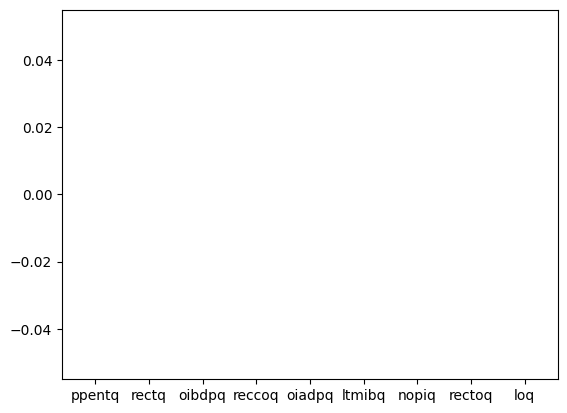

In [41]:
VarImpMean = VarImpResults.mean(axis=0)
VarImpMean = VarImpMean.sort_values()
#VarImpMean = VarImpMean/(VarImpMean.mean())
VarImpMean = VarImpMean[1:10]


import matplotlib.pyplot as plt
plt.bar(VarImpMean.index, VarImpMean, bottom=VarImpMean.min(), color ='maroon', width = 0.4)#, width, bottom, align)



In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




